# Correlation and Convolution

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True

Here we motivate and introduce the signal processing definitions of convolution and correlation. Understanding why convolution and correlation are useful for patten recognition will be key to understanding how neural networks detect patterns in data, and especially key to understanding how neural networks can detect subtle patterns in data.

Performing transforms on data is a key step to finding the most meaningful information in a dataset. Basic transforms, such as selecting data which meets a certain criteria in an array of data samples, and combining data from multiple data frames, are key steps we often perform intuitively when looking for patterns in data manually. Some of these transforms are intuitive, like removing rows with invalid samples, or removing outliers. Transforms on data can include formal mathematical transforms (like integral transforms) or common operations we do on data, like selecting certain rows and discarding others, that we might not think of as formal transforms in the mathematical sense but are still steps we take to transform our data.

More generally still, transforms on data can be performed manually or automatically, and can involve applying whatever operations we (or our algorithms) need to convert data to its most *meaningful* form. As a pre-requisite for transforming data into its most meaningful form (what does meaningful mean, anyway?), we need to start with a goal in mind. By transforming data with a goal in mind, we can evaluate candidate transforms based on whether or not they help us make progress towards our goal. Then, the most meaningful form is the form of the data which makes the patterns that serve our goal most evident. Example goals can be to detect the presence of a weak signal (e.g., to sense an object), to predict a pattern (e.g., the weather), or to discern the presence of one factor despite other distracting factors (e.g., to diagnose a disease).

Note that this is distinct from exploratory data analysis and routine data visualization in which we are simply looking to unpack and understand a dataset. When we apply advanced data transforms, we are often interested in designing a multi-stage *algorithm* (set of steps to solve a problem) which will help us see patterns in the data that others may not have seen. These patterns, patterns which our transforms can find in the data but others' cannot, are where the real value from data science starts to shine forth.

When we apply this mindset of designing a set of steps to find a pattern in the data that no one else has found before, we can draw a critical parallel to the heart of the scientific method, and the essence of the science of data science. In science, we are constantly making hypotheses based on the environments in which we performed experiments, and then repeating those experiments in different environments to see if our hypotheses hold true. When our hypotheses do not hold true in new environments, we adjust our theories from which they were derived to increase their explanatory power. As we expand and generalize our theories to explain new environments, we come closer to building a complete understanding of the world.

Similarly in data science, we strive to uncover insights in the data that no one else was able to uncover before. We then test those insights on new data, often by using them to build predictive models. When the models fail to predict the new data, we generalize the models to increase their explanatory power, until we develop models which explain the most diverse data with the least specific assumptions. When, through this process, we uncover models that do have unusual amounts of explanatory power, there is value to be found. For example, in curing diseases that haven't been cured before, sensing objects further away than ever before sensed, and automating processes never before automated. To achieve such feats of uniqueness, we require unique tools in our tool box. Our transforms, and the combinations of transforms we choose to apply, are these tools.

We will cover some of these tools for transforming data here, and more later this semester. We will start with transforms fundamental to understanding modern neural networks, namely correlation and convolution. We will build to understand correlation and convolution by learning to see multiplication as the simplest form of detecting patterns in data, and looking at a classical pattern recognition technique from the field of signal and image processing, the matched filter. From there, in the spirit of our study of Practical AI, we will look at how the convolutions implemented within neural networks differ **in practice** from the convolutions of mathematics and signal processing, while still serving the same overall goal despite being different in the details.

## Preliminaries

Before we start, we will need some basic mathematical tools. We will build up to an understanding of convolution by looking at a basic signal processing example. We use signal processing as an example due to convolution's origins in the field, and due to the intuition we can gain from seeing convolution in action.

The main motivation for data transformations, especially correlation and convolution, is to combat *noise*. Noise is caused by inevitable sources of randomness and error in nature. Recall from our basic definitions that we can never truly perceive a real object. We can only ascertain a percept, i.e., an approximation of that object as we see it. We can use increasingly sophisticated sensing mechanisms to drive our percepts as close as possible to ground truth, but the amount of error in our measurements of the real world will always be non-zero. This is due to flaws in our means of measuring, the finiteness of electronic and mechanical means of sensing (remember, a camera can only absorb so much light), inherent uncertainties (such as the "time-frequency acuity" trade off between accurately measuring the time at which an event occurred and the frequency in which the energy the event is comprised of oscillates at), and inherent randomness, such as noise in our environments, and noise in the components which comprise our sensors (e.g., due to heat). All these flaws and limitations are sources of noise in data.

The heart of data transformation is exploiting redundancy in our data to sense patterns despite the presence of noise which might appear to mask those patterns. We seek to combine the right parts of our data so that noise terms cancel as much as possible and so that the interesting data elements, i.e., those that contribute to our goals, combine in ways that shine through the noise to become apparent to us, and to other algorithms which might need to draw autonomous conclusions from that data. To study noisy data in this notebook, we introduce a simple noise adding function. This function accepts an array of a given size and adds noise from a gaussian distribution to that array. The function allows us to specify the signal to noise ratio (SNR) in decibels. The SNR for a signal $x[n]$ and noise $\eta[n]$ is defined as follows.

$$
\mathrm{SNR} = P_x / P_{\eta}
$$

Here $P_x$ is the power of the signal and $P_{\eta}$ is the power of the noise.

$$
P_{x} = \frac{1}{N} \sum_{n=1}^N x^2[n] \\
P_{\eta} = \frac{1}{N} \sum_{n=1}^N \eta^2[n] = \sigma^2
$$

For zero-mean, normally distributed $\eta$, noise power is equal to variance, i.e., $P_{\eta} = \sigma^2$.

For our simple demonstration, we will also need pulsed tone signals. Our pulsed tone signals will take the following form. Using a definition in continuous time, we have

$$
x(t) = (\theta(t - T_{S}) - \theta(t - T_{E})) \sin(2 \pi f t).
$$

Here, $\theta(t)$ represents the heaviside step, such that the tone turns on at time $T_S$ and turns off at time $T_E$.

For those familiar with Nyquist sampling, we will sample well above Nyquist rate throughout these notebooks to make some plots clearer.

We import functions for adding Gaussian noise and for generating pulse tone signals from a module outside this notebook.

[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Voltage (mV)'),
 Text(0.5, 1.0, '440 Hz Tone with -20 dB SNR')]

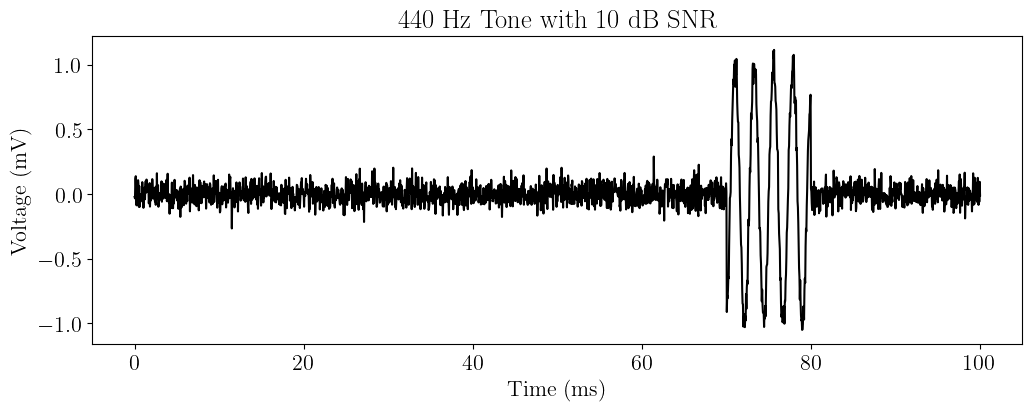

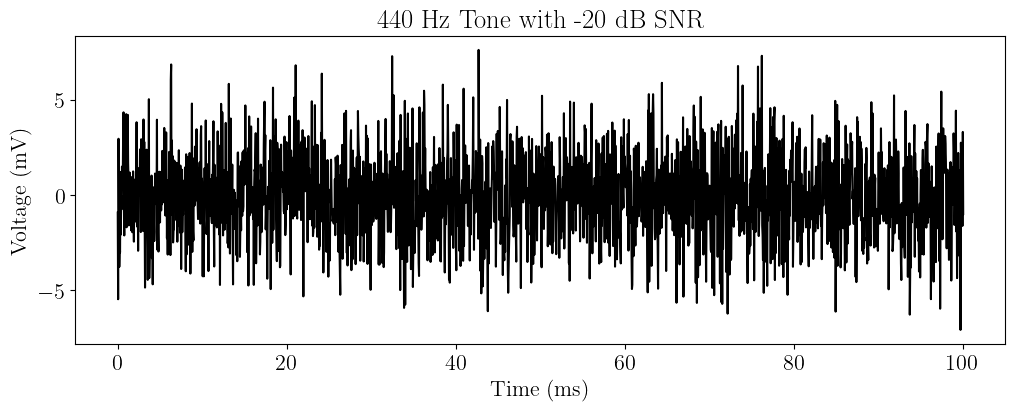

In [2]:
from signal_tools import add_white_gaussian_noise, generate_tone_signal

# Setup
SEC_TO_MSEC = 1e3
rng_seed = 1000
rng = np.random.default_rng(rng_seed)
end_time_seconds = 0.1
pulse_start_seconds = 0.07
pulse_end_seconds = 0.08
frequency1_hz = 440

# Generate a signal - sample well above Nyquist
sampling_frequency = frequency1_hz * 50
sampling_time_seconds = 1 / sampling_frequency
time_seconds = np.arange(0, end_time_seconds, sampling_time_seconds)

tone_signal = generate_tone_signal(
    time_seconds, pulse_start_seconds, pulse_end_seconds, frequency1_hz
)

# Add noise
snr_db = 10
noisy_signal = add_white_gaussian_noise(tone_signal, snr_db, rng)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds * SEC_TO_MSEC, noisy_signal, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title=f"440 Hz Tone with {snr_db} dB SNR",
)

# Add more noise
snr_db = -20
very_noisy_signal = add_white_gaussian_noise(tone_signal, snr_db, rng)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds * SEC_TO_MSEC, very_noisy_signal, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title=f"440 Hz Tone with {snr_db} dB SNR",
)

## Correlation

### Multiplication Example

Here we introduce correlation as a means of detecting patterns. We begin by using multiplication to find a pattern in some data.

In [3]:
x_signal = np.array(
    [
        0,
        0,
        0,
        0,
        0,
        1,
        0,
        1,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
    ]
)
template = np.array([1, 0, 1, 0, 1])

x_len = x_signal.shape[0]
t_len = template.shape[0]

valid_len = x_len - t_len + 1

products = []
summations = np.zeros((valid_len,))

for index in range(valid_len):
    equal_length_snippet_of_x_signal = x_signal[index : index + (t_len)]
    product = template * equal_length_snippet_of_x_signal
    sum_of_product = np.sum(product)

    # Keep track of intermediate results to understand the algorithm
    products.append(product)
    summations[index] = sum_of_product

In [4]:
# Inspect and see where the sum of the element-wise products will be high
products

[array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0])]

[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

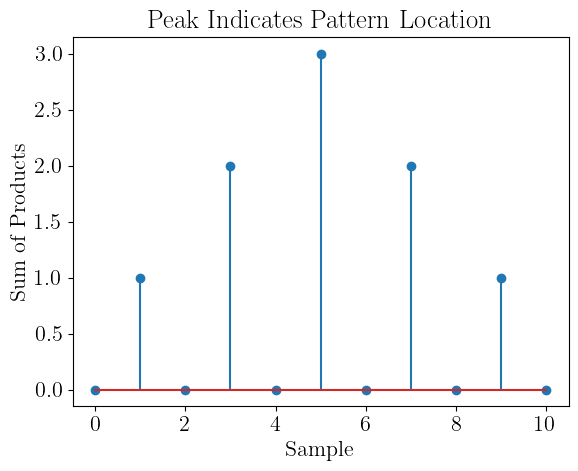

In [5]:
fig, ax = plt.subplots()
ax.stem(summations)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

### Using Numpy

We can use NumPy to perform this same function for us, implementing the signal processing definition of the cross-correlation via the [correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html) function.

Cross-correlation is defined on real-numbers as

$$
c[k] = \sum_{n} f[n+k] g[n]
$$

where the result $c$ has length

$$
L = L_g - L_f + 1.
$$

Here $L_g$ and $L_f$ are the lengths of $g$ and $f$ respectively. It is assumed $L_f < L_g$ and the $f$ is zero padded to match the length of $g$.

In [ ]:
correlation_result = np.correlate(x_signal, template, mode="valid")

fig, ax = plt.subplots()
ax.stem(correlation_result)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

## Applying Correlation to Pull Data Out of Noise!

[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Voltage (mV)'),
 Text(0.5, 1.0, 'Template Pulse')]

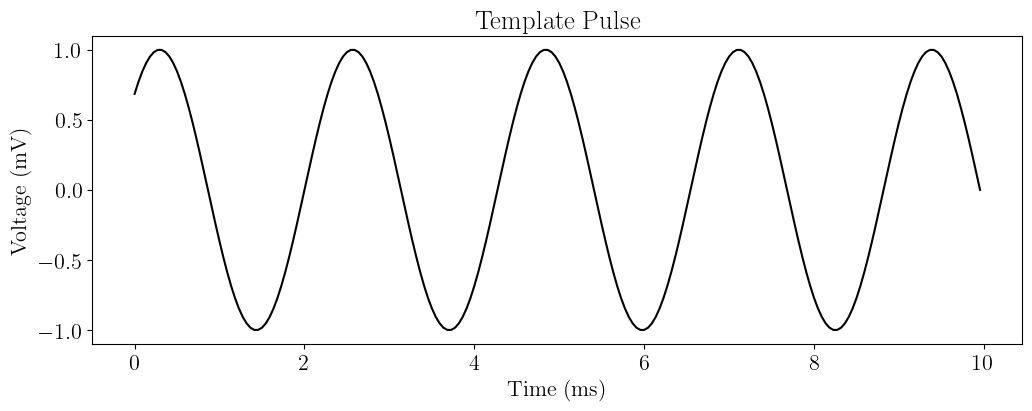

In [6]:
# Construct a Template Tone
pulse_length_seconds = pulse_end_seconds - pulse_start_seconds
template_time = time_seconds[time_seconds < pulse_length_seconds]
tone_template = np.sin(2 * np.pi * frequency1_hz * template_time)

# Time reverse the template
tone_template = tone_template[::-1]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(template_time * SEC_TO_MSEC, tone_template, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title="Template Pulse",
)

## Detect the Tone in Noise


[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

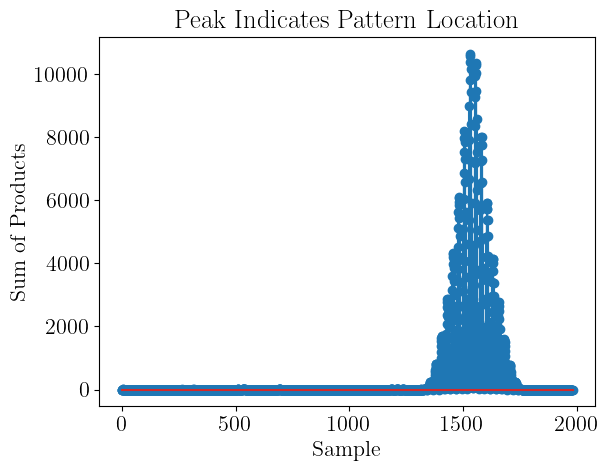

In [7]:
# Detect the Tone in Noise
tone_detection_output = np.correlate(noisy_signal, tone_template)

fig, ax = plt.subplots()
ax.stem(tone_detection_output**2)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

## Detect the Tone in Heavy Noise


[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

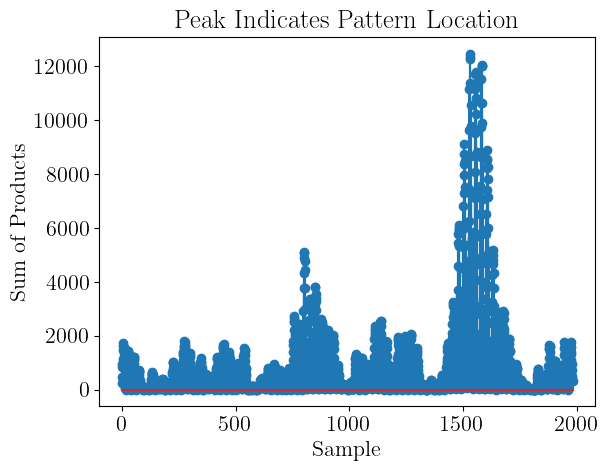

In [8]:
# Detect the Tone in Heavy Noise!
tone_detection_output = np.correlate(very_noisy_signal, tone_template)

fig, ax = plt.subplots()
ax.stem(tone_detection_output**2)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

## Convolution in Signal Processing

## Convolution in Neural Networks